In [1]:
!pip install bnlp_toolkit
!pip install banglanltk

  Obtaining dependency information for bnlp_toolkit from https://files.pythonhosted.org/packages/af/99/5d688fc2e5f6494d6c0a4e6bcdc8192266869caeef3b41dbc3dc8358616d/bnlp_toolkit-4.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
  Obtaining dependency information for python-crfsuite>=0.8.3 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.w

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Bidirectional
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,GRU
from wordcloud import WordCloud, STOPWORDS
# from bnlp.corpus import stopwords, punctuations
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import cv2
from keras.layers import Dropout
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import matplotlib.font_manager as fm
import banglanltk as bn
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import string
import emoji
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix,classification_report
%matplotlib inline



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read Image Mask And Bangla Font

In [3]:
my_image=np.array(Image.open("/kaggle/input/wodcloud-twiter-pic/twitter.png"))
my_font="/kaggle/input/wodcloud-twiter-pic/kalpurush.ttf"

# Read Real Data

In [4]:
real_data=pd.read_csv("/kaggle/input/banfakenews/Authentic-48K.csv")
real_data.head()

,articleID,domain,date,category,headline,content,label
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1


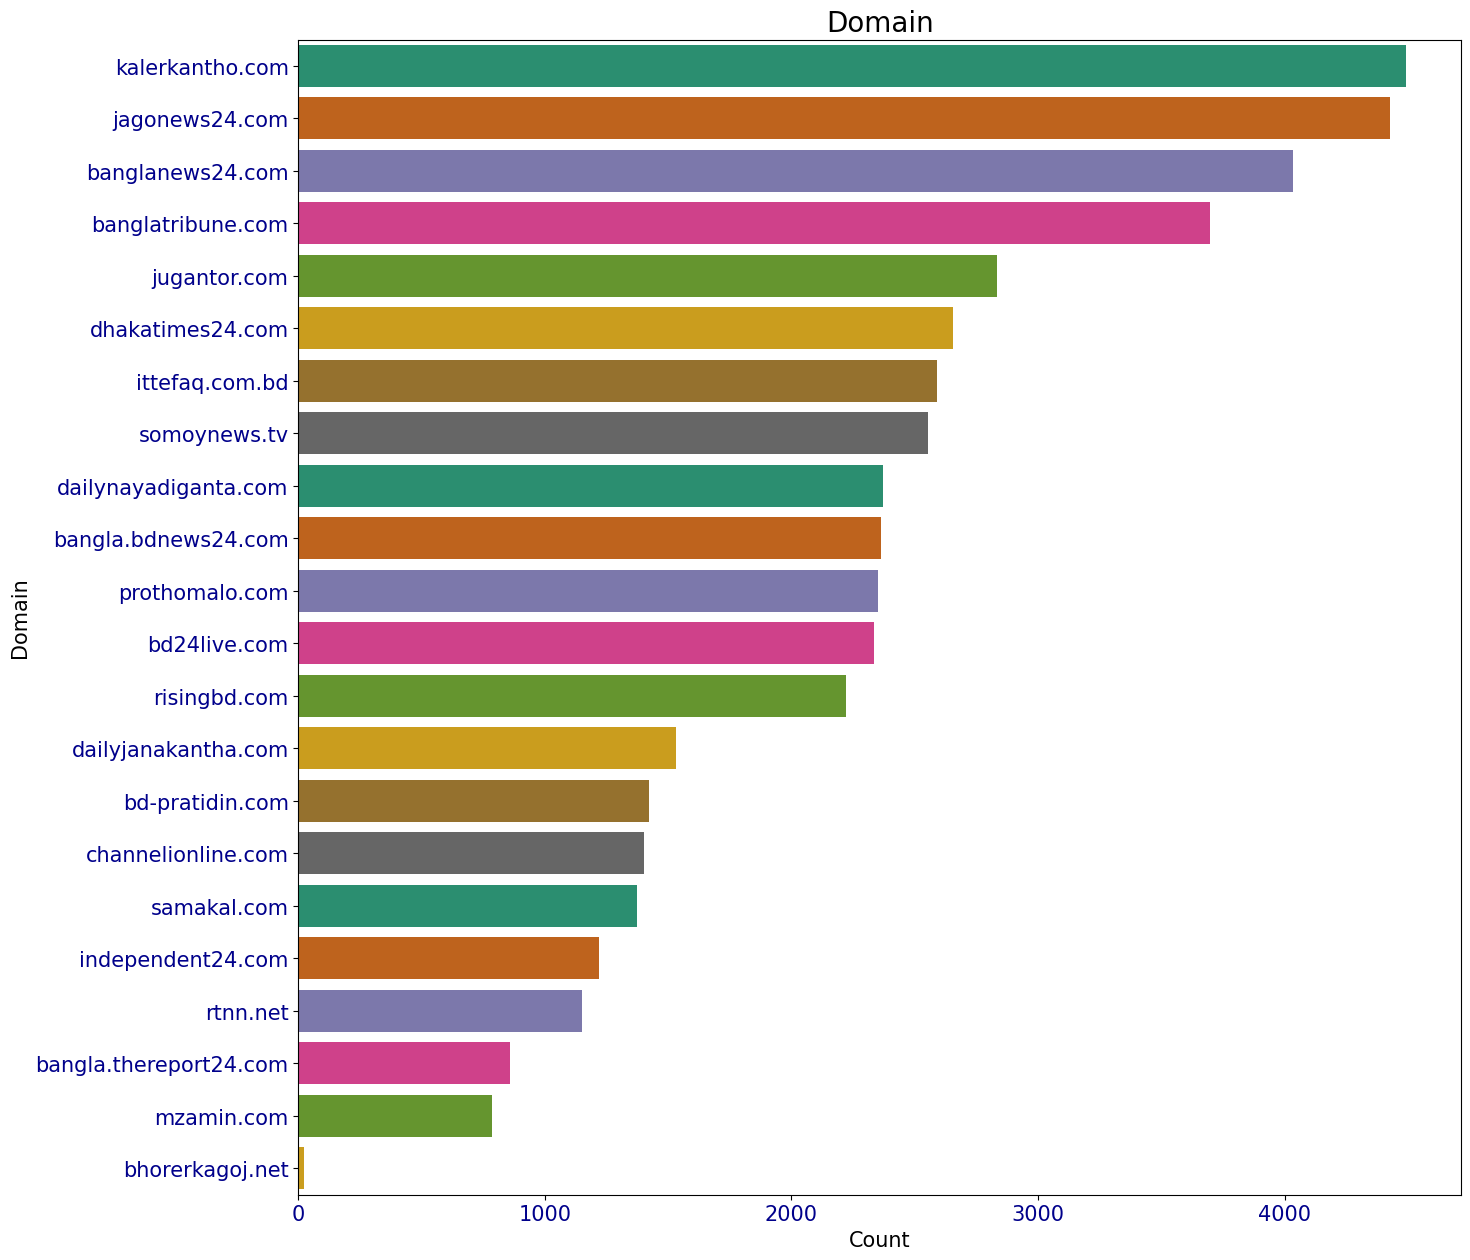

In [5]:
domain_counts = real_data['domain'].value_counts()
domain_order = domain_counts.index.tolist()

plt.figure(figsize=(15, 15))
sns.countplot(y="domain", data=real_data, palette="Dark2", order=domain_order)
plt.title("Domain",color="black",fontsize=20)
plt.xticks(fontsize=15,color="darkblue")
plt.yticks(fontsize=15,color="darkblue")
plt.xlabel("Count",fontsize=15,color="black")
plt.ylabel("Domain",fontsize=15,color="black")
plt.show()

# Read Fake Data

In [6]:
fake_data=pd.read_csv("/kaggle/input/banfakenews/Fake-1K.csv")
fake_data.head()

,articleID,domain,date,category,headline,content,label
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0


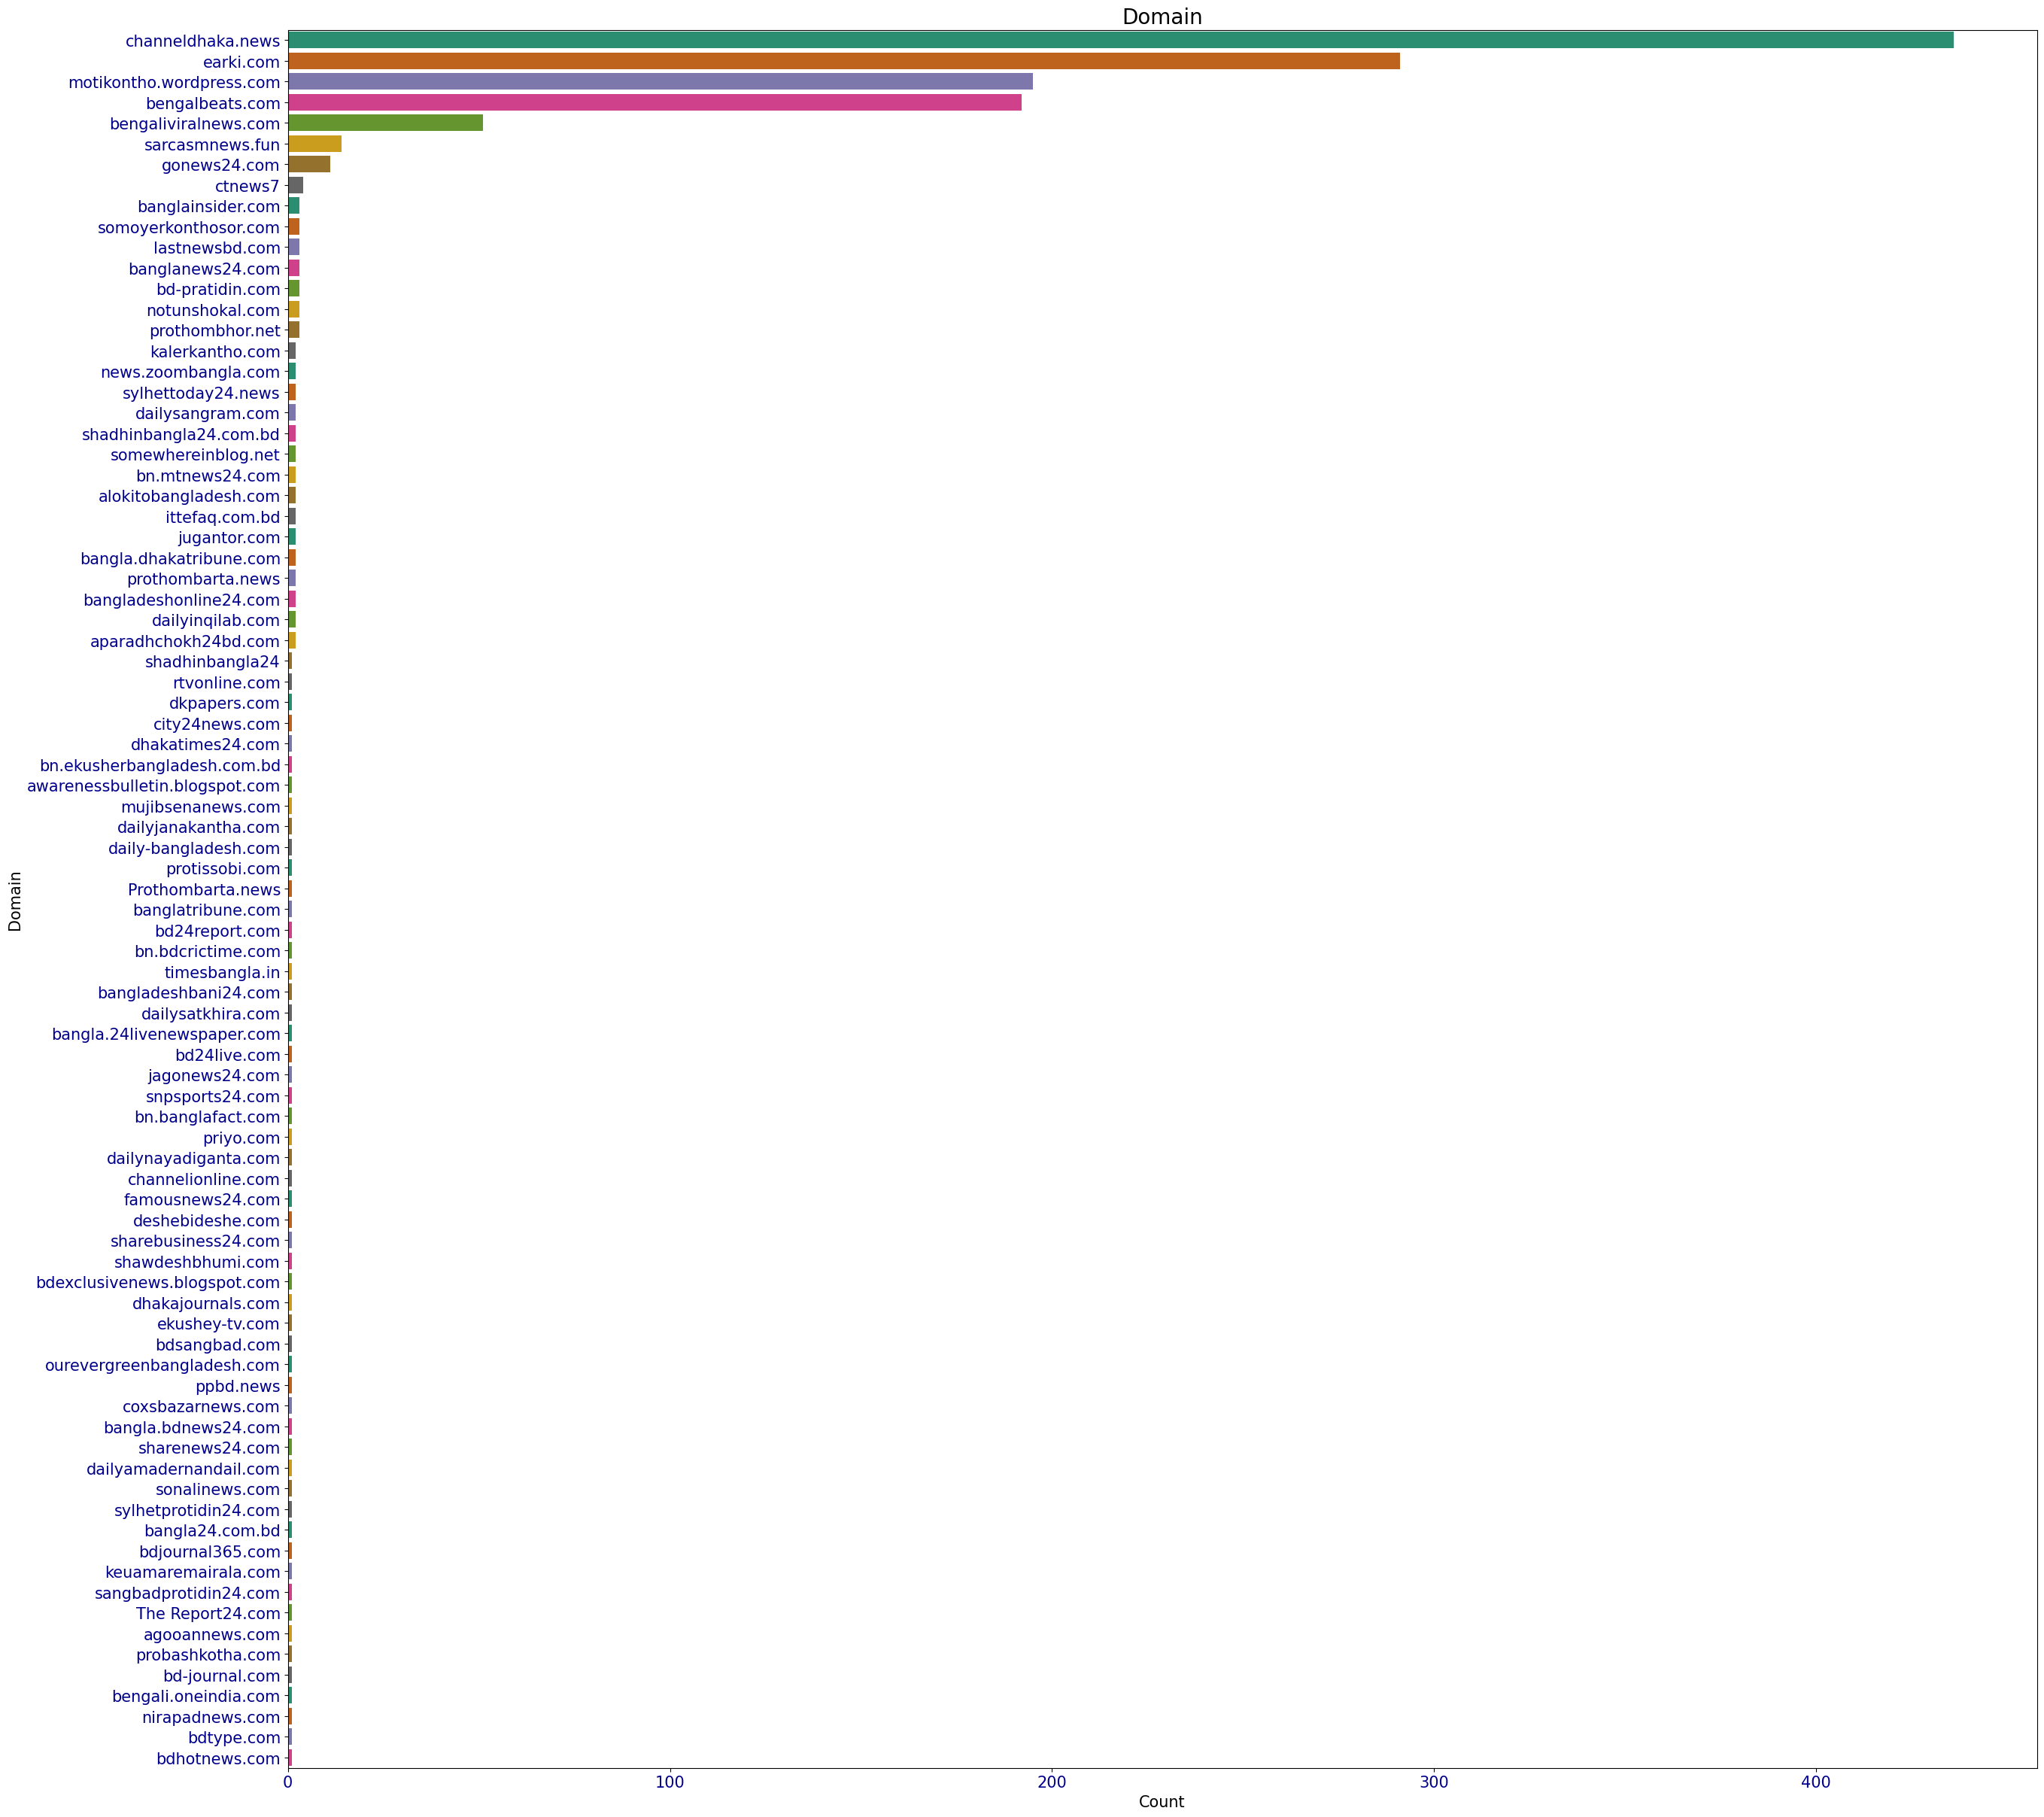

In [7]:
domain_counts = fake_data['domain'].value_counts()
domain_order = domain_counts.index.tolist()

plt.figure(figsize=(30,30))
sns.countplot(y="domain", data=fake_data, palette="Dark2", order=domain_order)
plt.title("Domain",color="black",fontsize=20)
plt.xticks(fontsize=15,color="darkblue")
plt.yticks(fontsize=15,color="darkblue")
plt.xlabel("Count",fontsize=15,color="black")
plt.ylabel("Domain",fontsize=15,color="black")
plt.show()

# Read Real Data Label

In [8]:
real_label=pd.read_csv("/kaggle/input/banfakenews/LabeledAuthentic-7K.csv")
real_label.head()

,articleID,domain,date,category,source,relation,headline,content,label
0,1,bd-pratidin.com,2018-09-20 08:16:43,Sports,আফগান ক্রিকেট বোর্ড (এসিবি) প্রধান,Related,হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ,ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান। কয়...,1.0
1,2,jugantor.com,2018-09-20 20:20:20,Sports,Reporter,Related,টস হেরে বোলিংয়ে বাংলাদেশ,এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...,1.0
2,3,bd24live.com,2018-09-20 16:39:40,National,Reporter,Related,রাজধানীতে বিশেষ অভিযানে আটক ৪৩,রাজধানীতে মাদক বিরোধী বিশেষ অভিযান পরিচালনা কর...,1.0
3,4,bd24live.com,2018-09-19 18:27:56,National,জননিরাপত্তা বিভাগের সচিব,Related,উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...,সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...,1.0
4,5,somoynews.tv,2018-09-20 10:15:28,Finance,পেট্রোল পাম্প মালিক সমিতি সভাপতি,Related,"'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'",ভারত থেকে পাইপ লাইনের মাধ্যমে সরাসরি দেশে জ্বা...,1.0


# Read Fake Data Label

In [9]:
fake_label=pd.read_csv("/kaggle/input/banfakenews/LabeledFake-1K.csv")
fake_label.head()

,articleID,domain,date,category,source,relation,headline,content,label,F-type
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,Reporter,Unrelated,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0,Satire
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,Reporter,Unrelated,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0,Satire
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,Reporter,Unrelated,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0,Satire
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,Reporter,Unrelated,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0,Satire
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,Reporter,Unrelated,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0,Satire


# Analysis Data

In [10]:
fake_data.isnull()

,articleID,domain,date,category,headline,content,label
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1294,False,False,False,False,False,False,False
1295,False,False,False,False,False,False,False
1296,False,False,False,False,False,False,False
1297,False,False,False,False,False,False,False


In [11]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   articleID  1299 non-null   int64 
 1   domain     1299 non-null   object
 2   date       1299 non-null   object
 3   category   1299 non-null   object
 4   headline   1299 non-null   object
 5   content    1299 non-null   object
 6   label      1299 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 71.2+ KB


In [12]:
real_data.isnull()

,articleID,domain,date,category,headline,content,label
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
48673,False,False,False,False,False,False,False
48674,False,False,False,False,False,False,False
48675,False,False,False,False,False,False,False
48676,False,False,False,False,False,False,False


In [13]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48678 entries, 0 to 48677
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   articleID  48678 non-null  int64 
 1   domain     48678 non-null  object
 2   date       48678 non-null  object
 3   category   48678 non-null  object
 4   headline   48678 non-null  object
 5   content    48678 non-null  object
 6   label      48678 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.6+ MB


In [14]:
fake_data.shape

(1299, 7)

In [15]:
real_data.shape

(48678, 7)

# Count Fake Data Each Category

In [16]:
fake_data["category"].value_counts()

category
Miscellaneous    654
Entertainment    106
Lifestyle        102
National          99
International     91
Politics          90
Sports            54
Crime             42
Education         30
Technology        29
Finance            2
Name: count, dtype: int64

# Fake Data Category Visualize

/tmp/ipykernel_26/4038474509.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


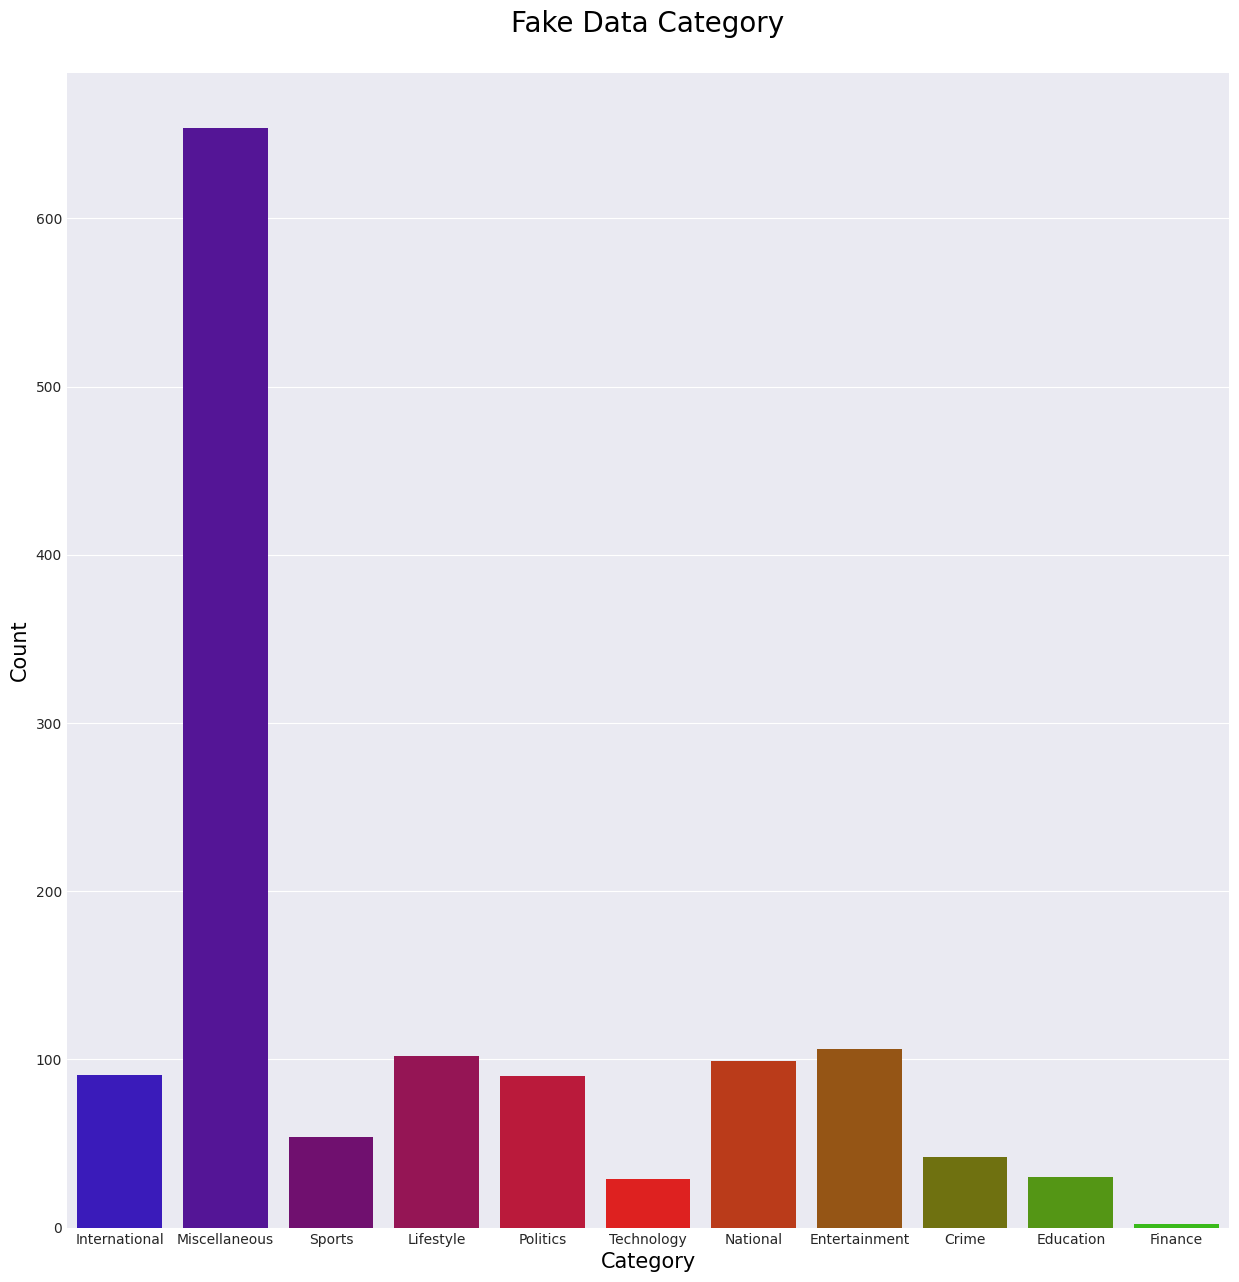

In [17]:
plt.figure(figsize=(15,15))
plt.style.use("seaborn-darkgrid")
sns.countplot(x="category",data=fake_data,palette="brg")
plt.title("Fake Data Category\n",color="black",fontsize=20)
plt.xlabel("Category",fontsize=15,color="black")
plt.ylabel("Count",fontsize=15,color="black")
plt.show()

# Count Real Data Each Category

In [18]:
real_data["category"].value_counts()

category
National         18708
International     6990
Sports            6526
Editorial         3504
Politics          2941
Entertainment     2636
Miscellaneous     2218
Finance           1224
Education         1115
Crime             1072
Lifestyle          901
Technology         843
Name: count, dtype: int64

# Real Data Category Visualize

/tmp/ipykernel_26/1696219580.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark-palette")


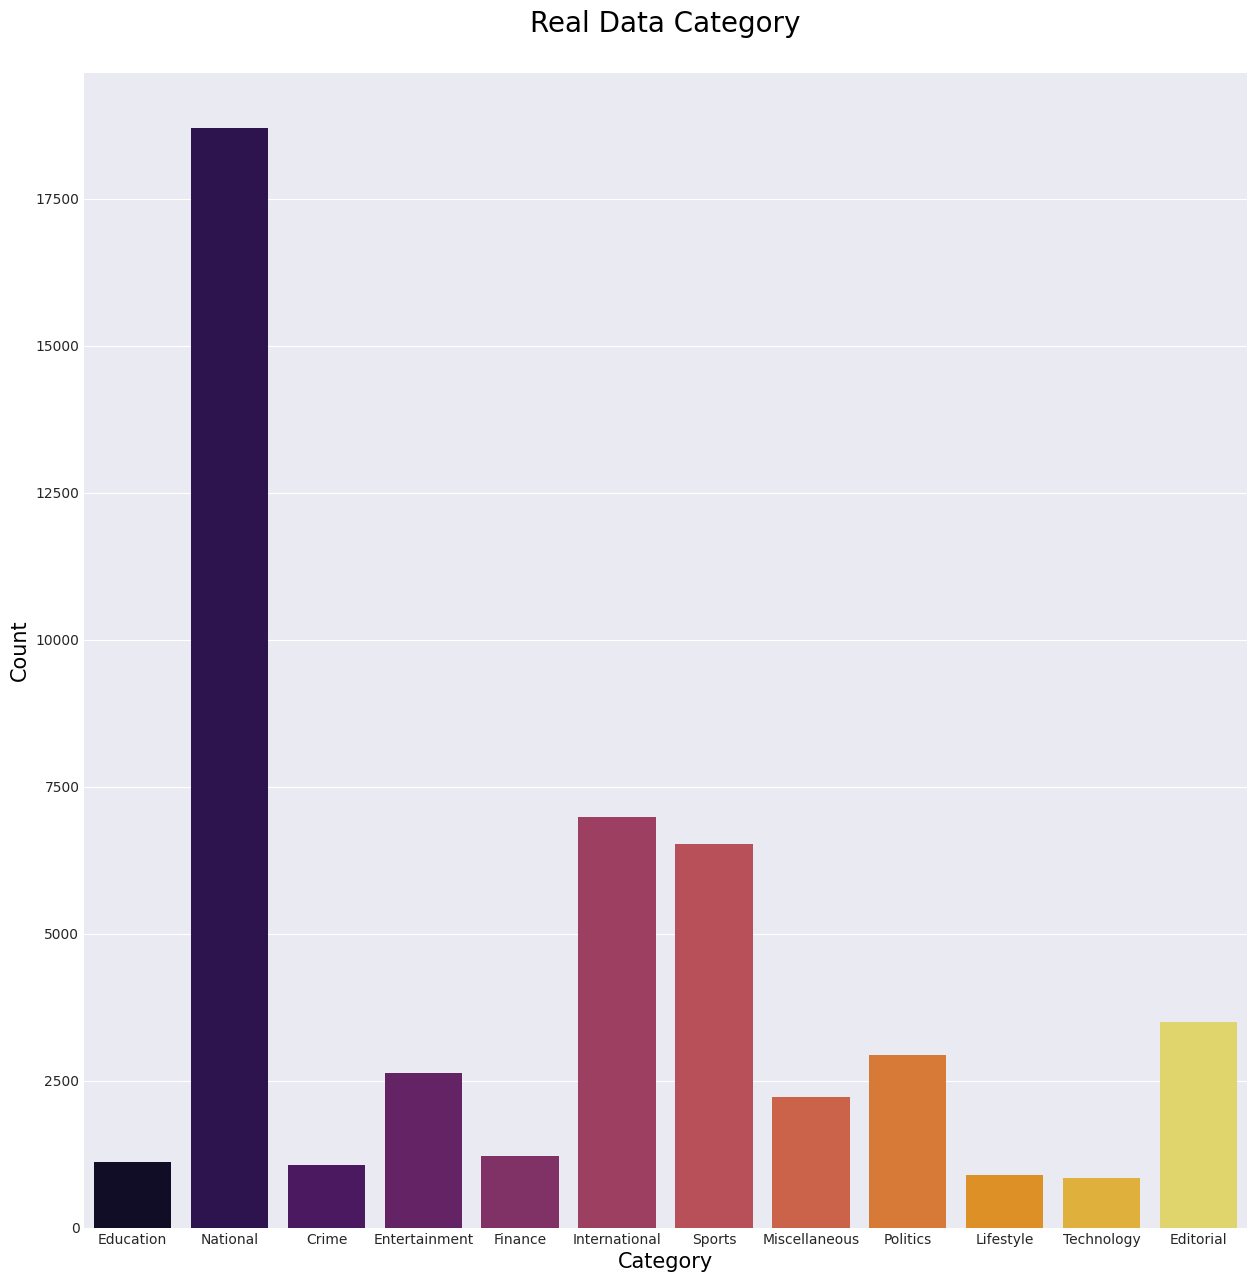

In [19]:
plt.figure(figsize=(15,15))
plt.style.use("seaborn-dark-palette")
sns.countplot(x="category",data=real_data,palette="inferno")
plt.title("Real Data Category\n",color="black",fontsize=20)
plt.xlabel("Category",fontsize=15,color="black")
plt.ylabel("Count",fontsize=15,color="black")
plt.show()

# Drop unnecessary columns

In [20]:
real_data=real_data.drop(["articleID","domain","date","category"],axis=1)

In [21]:
fake_data=fake_data.drop(["articleID","domain","date","category"],axis=1)

In [22]:
real_data.head()

,headline,content,label
0,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1


In [23]:
fake_data.head()

,headline,content,label
0,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0
1,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0
2,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0
3,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0
4,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0


# Concatenate the Fake Data 'headline' and 'content' columns

In [24]:

fake_data['text'] = fake_data['headline'] + ' ' + fake_data['content']
# Remove the original 'headline' and 'content' columns
fake_data.drop(columns=['headline', 'content'], inplace=True)
fake_data.head()

,label,text
0,0,মুরগির হামলায় শেয়াল নিহত বাংলায় একটা প্রবাদ আছ...
1,0,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম BTV থে...
2,0,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...
3,0,অবসর নেয়ার ঘোষণা দিলেন মেসি ! রাশিয়া বিশ্বকাপ ...
4,0,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি..."


# Concatenate the Real Data 'headline' and 'content' Columns

In [25]:

real_data['text'] = real_data['headline'] + ' ' + real_data['content']
# Remove the original 'headline' and 'content' columns
real_data.drop(columns=['headline', 'content'], inplace=True)
real_data.head()

,label,text
0,1,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শো..."
1,1,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারি...
2,1,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...
3,1,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...
4,1,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু মাদ...


In [26]:
import re
from bnlp import BengaliCorpus as corpus
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def clean(text, punctuations):
    text = re.sub('[%s]' % re.escape(punctuations), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\xa0', '', text)
    return text


print(corpus.stopwords)
print(corpus.punctuations)
print(corpus.letters)
print(corpus.digits)
print(corpus.vowels)

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

#  Real Data Wordcloud

In [27]:
# wordcloud_real_text = real_data['text'].apply(lambda x: clean(str(x),corpus.punctuations))
# wordcloud_text = " ".join(wordcloud_real_text)
# regex = r"[\u0980-\u09FF]+"
# wc = WordCloud(width=1200, height=1200, background_color="black", colormap="plasma", mask=my_image, stopwords=corpus.stopwords,
#                font_path=my_font, regexp=regex,max_words=500, random_state=42).generate(wordcloud_text)

# plt.figure(figsize=(15, 15))
# plt.imshow(wc, interpolation='bilinear')
# plt.tight_layout()
# plt.axis("off")
# plt.show()

# Fake Data Wordcloud

In [28]:
# wordcloud_fake_text = fake_data['text'].apply(lambda x: clean(str(x),corpus.punctuations))
# wordcloud_text_fake = " ".join(wordcloud_fake_text)
# regex = r"[\u0980-\u09FF]+"
# wc = WordCloud(width=1200, height=1200, background_color="lightcyan", colormap="gnuplot", mask=my_image, stopwords=corpus.stopwords,
#                font_path=my_font, regexp=regex,max_words=500, random_state=42).generate(wordcloud_text_fake)

# plt.figure(figsize=(15, 15))
# plt.imshow(wc, interpolation='bilinear')
# plt.tight_layout()
# plt.axis("off")
# plt.show()

# Most Common Words In Real Data

In [29]:
# # Load a custom font that supports Bengali characters
# my_font = fm.FontProperties(fname="/kaggle/input/wodcloud-twiter-pic/kalpurush.ttf")

# # Clean the text data
# cleaned_data = real_data['text'].apply(lambda x: clean(str(x),corpus.punctuations))

# # Split the text into individual words and count their frequency
# top_words = cleaned_data.str.split(expand=True).stack().value_counts().head(30)

# # Create the plot using the custom font
# plt.figure(figsize=(18,18))
# sns.barplot(x=top_words.index, y=top_words.values,palette="tab10")
# plt.title('Top 30 Most Common Words in Real Data', fontproperties=my_font,fontsize=20,color="black")
# plt.xlabel('Word', fontproperties=my_font,fontsize=15,color="black")
# plt.ylabel('Frequency', fontproperties=my_font,fontsize=15,color="black")
# plt.xticks(rotation=90, fontproperties=my_font,fontsize=15,color="navy")
# plt.yticks(fontproperties=my_font,fontsize=15,color="navy")
# plt.show()


In [30]:
# # Clean the text data
# cleaned_data = fake_data['text'].apply(lambda x: clean(str(x),corpus.punctuations))

# # Split the text into individual words and count their frequency
# top_words = cleaned_data.str.split(expand=True).stack().value_counts().head(30)

# # Create the plot using the custom font
# plt.figure(figsize=(18,18))
# sns.barplot(x=top_words.index, y=top_words.values,palette="tab20")
# plt.title('Top 30 Most Common Words in Fake Data', fontproperties=my_font,fontsize=20,color="black")
# plt.xlabel('Word', fontproperties=my_font,fontsize=15,color="black")
# plt.ylabel('Frequency', fontproperties=my_font,fontsize=15,color="black")
# plt.xticks(rotation=90, fontproperties=my_font,fontsize=15,color="darkred")
# plt.yticks(fontproperties=my_font,fontsize=15,color="darkred")
# plt.show()


# Real Data String Length

In [31]:
# plt.style.use("seaborn-darkgrid")
# # Calculate the text length in characters
# real_data_len= real_data['text'].apply(lambda x: len(x))

# # Create a histogram and a KDE plot of the text length using displot
# sns.displot(real_data_len, kde=True, bins=50,height=8,color="darkorange")
# plt.title("Real Data Length\n",color="darkorange",fontsize=15)
# plt.xlabel('Text length',fontsize=10,color="darkorange")
# plt.ylabel('Count',fontsize=10,color="darkorange")
# plt.show()


# Fake Data Length

In [32]:
# plt.style.use("seaborn-darkgrid")
# # Calculate the text length in characters
# fake_data_len= fake_data['text'].apply(lambda x: len(x))

# # Create a histogram and a KDE plot of the text length using displot
# sns.displot(fake_data_len, kde=True, bins=50,height=8,color="darkgreen")
# plt.title("Fake Data Length\n",color="darkgreen",fontsize=15)
# plt.xlabel('Text length',fontsize=10,color="darkgreen")
# plt.ylabel('Count',fontsize=10,color="darkgreen")
# plt.show()



In [33]:
# real_data_len=real_data["text"].str.len()
# fake_data_len=fake_data["text"].str.len()
# plt.figure(figsize=(10,10))
# plt.hist(real_data_len, bins=100,label='Real_Data_Length',color="navy")
# plt.hist(fake_data_len , bins=100, label='Fake_Data_Length',color="crimson")
# plt.title("Real Data Length Vs Fake Data Length\n",fontsize=15,color="brown")
# plt.legend()
# plt.show()

In [34]:
real_data.head()

,label,text
0,1,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শো..."
1,1,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারি...
2,1,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...
3,1,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...
4,1,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু মাদ...


In [35]:
fake_data.head()

,label,text
0,0,মুরগির হামলায় শেয়াল নিহত বাংলায় একটা প্রবাদ আছ...
1,0,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম BTV থে...
2,0,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...
3,0,অবসর নেয়ার ঘোষণা দিলেন মেসি ! রাশিয়া বিশ্বকাপ ...
4,0,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি..."


In [36]:
import pandas as pd
print(pd.__version__)


2.1.4


In [37]:
# # append the rows of fake_data to real_data and reset the index
# append_data = real_data.append(fake_data).reset_index(drop=True)
# final_data= append_data.sample(frac=1, random_state=42).reset_index(drop=True)
# final_data.head()
# Concatenate the DataFrames and reset the index
append_data = pd.concat([real_data, fake_data], ignore_index=True)
final_data = append_data.sample(frac=1, random_state=42).reset_index(drop=True)
final_data.head()



,label,text
0,1,‘সাংবাদিকতাকে সাহিত্যে উত্তীর্ণ করেছিলেন গোলাম...
1,1,নেইমারের দুর্দান্ত হ্যাটট্রিকে পিএসজির বিশাল জ...
2,1,ডিজিটাল নিরাপত্তা আইন নিয়ে যা বললেন জয় জাতীয়...
3,1,দেশ দখলের ঘোষণার প্রতিবাদ প্রধানমন্ত্রী করলেন ...
4,1,শিশুদের ক্যানভাসে প্রধানমন্ত্রীর জন্মদিন নানা ...


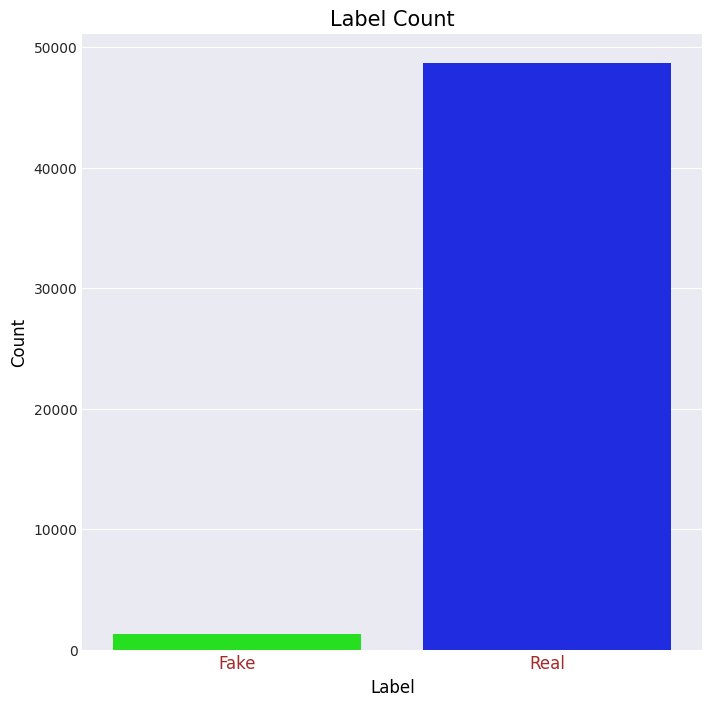

In [38]:
plt.figure(figsize=(8,8))
sns.countplot(x="label",data=final_data,palette="hsv")
plt.title("Label Count",fontsize=15,color="black")
plt.xlabel("Label",fontsize=12,color="black")
plt.ylabel("Count",fontsize=12,color="black")
xticklabels = ["Fake", "Real"]
plt.xticks(ticks=[0, 1], labels=xticklabels,fontsize=12,color="brown")

plt.show()

In [39]:

# def remove_html_tags(text):
#     return BeautifulSoup(text, 'html.parser').get_text()

# def remove_punctuation(text):
#     text = ''.join([c for c in text if c not in string.punctuation])
#     return text

# def remove_extra_whitespace_tabs(text):
#     pattern = r'^\s*|\s\s*'
#     return re.sub(pattern, ' ', text).strip()

# def bn_lemmatization(text):

#     return bn.stemmer(text)

# def remove_bn_stopwords(text):
#     final_text = []
#     for word in text.split():
#         if word not in nltk_stopwords.words('bengali'):
#             final_text.append(word)
#     return " ".join(final_text)

# def remove_bangla_digits(text):
#     bn_digits = ["০", "১", "২", "৩", "৪", "৫", "৬", "৭", "৮", "৯"]
#     for d in bn_digits:
#         text = text.replace(d, "")
#     return text

# def remove_emojis(text):
#     text = emoji.get_emoji_regexp().sub(u'', text)
#     return text

# def cleaning(text):
#     text = remove_html_tags(text)
#     text = remove_bn_stopwords(text)
#     text = remove_punctuation(text)
#     text = remove_extra_whitespace_tabs(text)
#     text = bn_lemmatization(text)
#     text = remove_bangla_digits(text)
#     text = remove_emojis(text)
#     return text


In [40]:
with open('/kaggle/input/wodcloud-twiter-pic/stopwords-bn.txt', 'r', encoding='utf-8-sig') as f:
    stop_word = f.read()
    stop_word = stop_word.replace(" ", "")
    stop_word = stop_word.split('\n')
    print(stop_word)

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

In [41]:
final_data.head()

,label,text
0,1,‘সাংবাদিকতাকে সাহিত্যে উত্তীর্ণ করেছিলেন গোলাম...
1,1,নেইমারের দুর্দান্ত হ্যাটট্রিকে পিএসজির বিশাল জ...
2,1,ডিজিটাল নিরাপত্তা আইন নিয়ে যা বললেন জয় জাতীয়...
3,1,দেশ দখলের ঘোষণার প্রতিবাদ প্রধানমন্ত্রী করলেন ...
4,1,শিশুদের ক্যানভাসে প্রধানমন্ত্রীর জন্মদিন নানা ...


In [42]:
# final_data['num_characters'] = final_data['text'].apply(len)

In [43]:
# final_data['num_words'] = final_data['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [44]:
# final_data['num_sentences'] = final_data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [45]:
# final_data[['num_characters', 'num_words', 'num_sentences']].describe()

In [46]:
# final_data[final_data['label']==0][['num_characters', 'num_words', 'num_sentences']].describe()

In [47]:
# final_data[final_data['label']==1][['num_characters', 'num_words', 'num_sentences']].describe()

In [48]:
# plt.figure(figsize=(10,10))
# sns.histplot(final_data[final_data['label']==1]['num_characters'], color='blue')
# sns.histplot(final_data[final_data['label']==0]['num_characters'],color="yellow")
# plt.show()

In [49]:
# plt.figure(figsize=(10,10))
# sns.histplot(final_data[final_data['label']==1]['num_words'], color='orange')
# sns.histplot(final_data[final_data['label']==0]['num_words'],color="green")
# plt.show()


In [50]:
# plt.figure(figsize=(10,10))
# sns.histplot(final_data[final_data['label']==1]['num_sentences'], color='purple',bins=100)
# sns.histplot(final_data[final_data['label']==0]['num_sentences'],color="gold",bins=100)
# plt.show()

In [51]:
# plt.figure(figsize=(10,10))
# my_color=["red","green"]
# my_marker=["D","P"]
# sns.pairplot(final_data,hue="label",palette=my_color,height=3,markers=my_marker,plot_kws={"s":100})
# plt.show()

In [52]:
# final_data=final_data.drop(["num_characters","num_words","num_sentences"],axis=1)

In [53]:
def clean_text(text):
    row = str(text)
    row = row.replace('\n', ' ')
    row = row.replace('\t', ' ')
    row = row.replace('\\', "")
    row = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', row)
    row = re.sub(' +', ' ', row)
    row = row.replace("।", "")
    row = re.sub('[১২৩৪৫৬৭৮৯০]', '', row)
    row = re.sub('[1234567890]', '', row)
    row = row.replace('’', '')
    row = row.replace('‘', '')

    # Removing stop words
    row = row.split()
    row = [w for w in row if not w in stop_word]
    row = " ".join(row)
    return row

In [54]:
final_data['text'] = final_data['text'].apply(clean_text)

In [55]:
final_data.head()

,label,text
0,1,সাংবাদিকতাকে সাহিত্যে উত্তীর্ণ গোলাম সারওয়ার স...
1,1,নেইমারের দুর্দান্ত হ্যাটট্রিকে পিএসজির বিশাল জ...
2,1,ডিজিটাল নিরাপত্তা আইন জয় জাতীয় সংসদে সদ্য পাস...
3,1,দেশ দখলের ঘোষণার প্রতিবাদ প্রধানমন্ত্রী অক্টোব...
4,1,শিশুদের ক্যানভাসে প্রধানমন্ত্রীর জন্মদিন রঙের ...


In [56]:
avg=final_data['text'].apply(len)
avg_len=avg.mean()
print(f"Average Text Length: {avg_len}")

Average Text Length: 1464.8318826660263


In [57]:
final_data["label"].value_counts()


label
1    48678
0     1299
Name: count, dtype: int64

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import scikitplot as skplt
from sklearn.metrics import precision_score, cohen_kappa_score, roc_auc_score, matthews_corrcoef, log_loss, brier_score_loss

In [59]:
tf = TfidfVectorizer()
train_data=tf.fit_transform(final_data["text"])
label_data=final_data["label"]
X_train, X_test, y_train, y_test = train_test_split(train_data, label_data, test_size=0.2, random_state=42)


# Model_1 Naive Bayes

In [60]:
model1=MultinomialNB()
model1.fit(X_train,y_train)
pred1=model1.predict(X_test)
accuracy1 = accuracy_score(y_test, pred1)
print(f'Accuracy: {accuracy1:.2f}%')

Accuracy: 0.97%


<Figure size 1000x600 with 0 Axes>

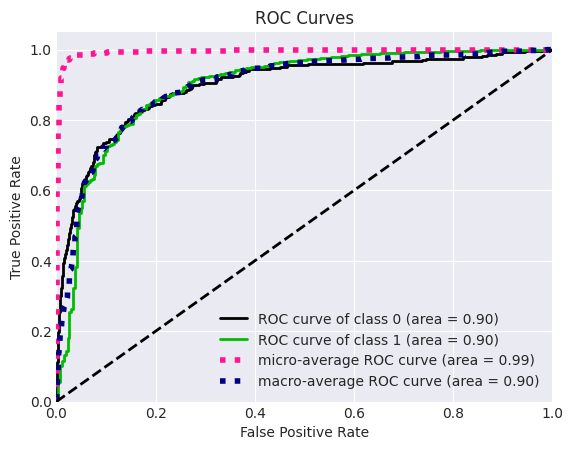

In [61]:
plt.figure(figsize=(10,6))
prob1=model1.predict_proba(X_test)
skplt.metrics.plot_roc(y_test,prob1)
plt.show()

<Figure size 800x700 with 0 Axes>

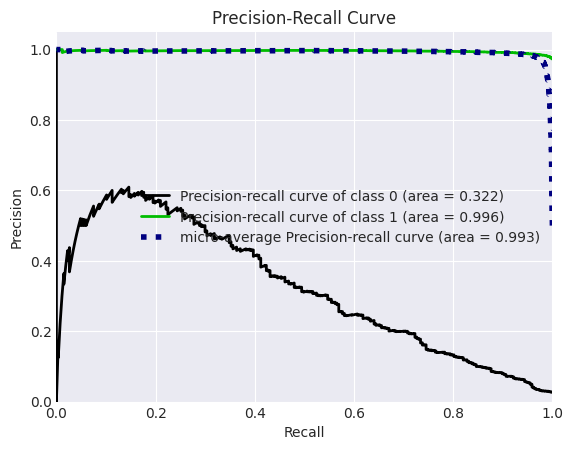

In [62]:
plt.figure(figsize=(8,7))
skplt.metrics.plot_precision_recall(y_test,prob1)
plt.show()

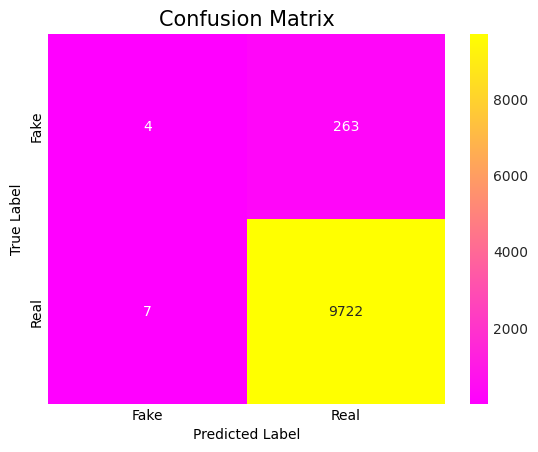

In [63]:
label_name=["Fake","Real"]
cf1= confusion_matrix(y_test,pred1)
sns.heatmap(cf1,annot=True,fmt="d",xticklabels=label_name,yticklabels=label_name,cmap="spring")
plt.xlabel("Predicted Label",fontsize=10,color="black")
plt.ylabel("True Label",fontsize=10,color="black")
plt.title("Confusion Matrix",fontsize=15,color="black")
plt.xticks(fontsize=10,color="black")
plt.yticks(fontsize=10,color="black")
plt.show()

In [64]:
print(classification_report(y_test,pred1,target_names=label_name))

              precision    recall  f1-score   support

        Fake       0.36      0.01      0.03       267
        Real       0.97      1.00      0.99      9729

    accuracy                           0.97      9996
   macro avg       0.67      0.51      0.51      9996
weighted avg       0.96      0.97      0.96      9996



# Precision Score,Kappa Score

In [65]:
# Calculating precision score
precision = precision_score(y_test,pred1)
print("=================================================================")
# Printing the precision score
print('Precision Score: %.4f' % precision)
print("=================================================================")
kappa_score = cohen_kappa_score(y_test,pred1)

# Printing the kappa score
print('Cohen\'s Kappa Score: %.4f' % kappa_score)
print("=================================================================")
roc_auc = roc_auc_score(y_test,pred1)

# Printing the ROC AUC score
print('ROC AUC Score: %.4f' % roc_auc)
print("=================================================================")
# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test,pred1)
# Printing the MCC
print('MCC Score: %.4f' % mcc)
print("=================================================================")
log_loss_score = log_loss(y_test,pred1)

# Printing the logarithmic loss
print('Logarithmic Loss: %.4f' % log_loss_score)
print("=================================================================")

brier_score = brier_score_loss(y_test,pred1)

# Printing the Brier score
print('Brier Score: %.3f' % brier_score)
print("=================================================================")

Precision Score: 0.9737
Cohen's Kappa Score: 0.0267
ROC AUC Score: 0.5071
MCC Score: 0.0694
Logarithmic Loss: 0.9736
Brier Score: 0.027


# Model_2 GradientBoostingClassifier

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
model2=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model2.fit(X_train,y_train)
pred2=model2.predict(X_test)
accuracy2 = accuracy_score(y_test, pred2)
print(f'Accuracy: {accuracy2:.2f}%')

Accuracy: 0.98%


<Figure size 1000x600 with 0 Axes>

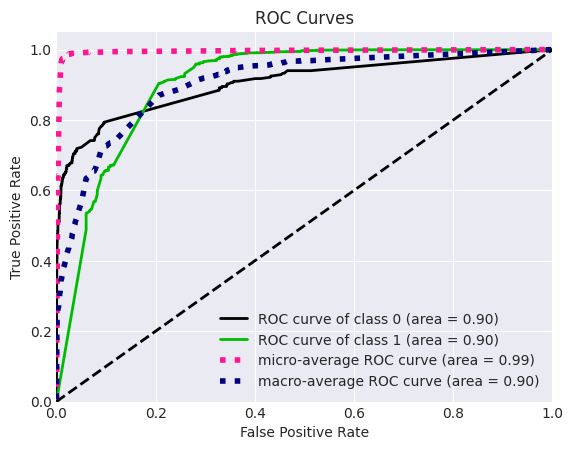

In [67]:
plt.figure(figsize=(10,6))
prob2=model2.predict_proba(X_test)
skplt.metrics.plot_roc(y_test,prob2)
plt.show()

<Figure size 800x700 with 0 Axes>

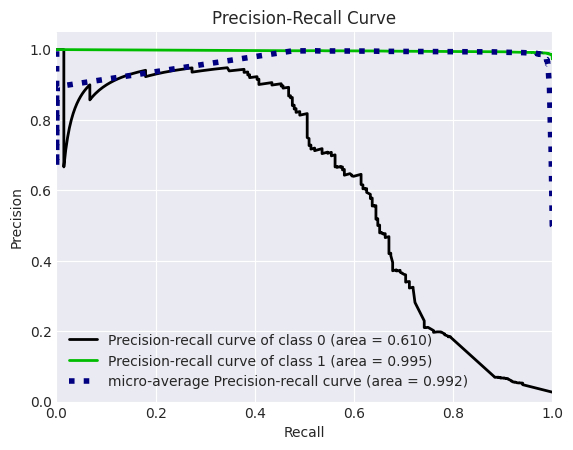

In [68]:
plt.figure(figsize=(8,7))
skplt.metrics.plot_precision_recall(y_test,prob2)
plt.show()

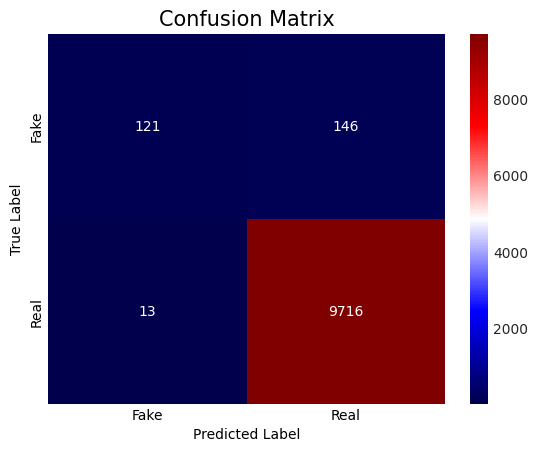

In [69]:
label_name=["Fake","Real"]
cf1= confusion_matrix(y_test,pred2)
sns.heatmap(cf1,annot=True,fmt="d",xticklabels=label_name,yticklabels=label_name,cmap="seismic")
plt.xlabel("Predicted Label",fontsize=10,color="black")
plt.ylabel("True Label",fontsize=10,color="black")
plt.title("Confusion Matrix",fontsize=15,color="black")
plt.xticks(fontsize=10,color="black")
plt.yticks(fontsize=10,color="black")
plt.show()

In [70]:
print(classification_report(y_test,pred2,target_names=label_name))

              precision    recall  f1-score   support

        Fake       0.90      0.45      0.60       267
        Real       0.99      1.00      0.99      9729

    accuracy                           0.98      9996
   macro avg       0.94      0.73      0.80      9996
weighted avg       0.98      0.98      0.98      9996



In [71]:
# Calculating precision score
precision2 = precision_score(y_test,pred2)
print("=================================================================")
# Printing the precision score
print('Precision Score: %.4f' % precision2)
print("=================================================================")
kappa_score2 = cohen_kappa_score(y_test,pred2)

# Printing the kappa score
print('Cohen\'s Kappa Score: %.4f' % kappa_score2)
print("=================================================================")
roc_auc2 = roc_auc_score(y_test,pred2)

# Printing the ROC AUC score
print('ROC AUC Score: %.4f' % roc_auc2)
print("=================================================================")
# Matthews Correlation Coefficient
mcc2 = matthews_corrcoef(y_test,pred2)
# Printing the MCC
print('MCC Score: %.4f' % mcc2)
print("=================================================================")
log_loss_score2 = log_loss(y_test,pred2)

# Printing the logarithmic loss
print('Logarithmic Loss: %.4f' % log_loss_score2)
print("=================================================================")

brier_score2 = brier_score_loss(y_test,pred2)

# Printing the Brier score
print('Brier Score: %.3f' % brier_score2)
print("=================================================================")

Precision Score: 0.9852
Cohen's Kappa Score: 0.5963
ROC AUC Score: 0.7259
MCC Score: 0.6335
Logarithmic Loss: 0.5733
Brier Score: 0.016


# Model_3 AdaBoostClassifier

In [72]:
from sklearn.ensemble import AdaBoostClassifier
model3=AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
model3.fit(X_train,y_train)
pred3=model3.predict(X_test)
accuracy3 = accuracy_score(y_test, pred3)
print(f'Accuracy: {accuracy3:.2f}%')

Accuracy: 0.98%


<Figure size 1000x600 with 0 Axes>

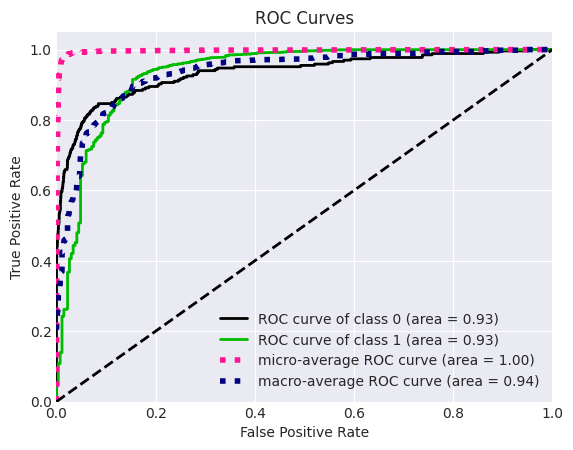

In [73]:
plt.figure(figsize=(10,6))
prob3=model3.predict_proba(X_test)
skplt.metrics.plot_roc(y_test,prob3)
plt.show()

<Figure size 800x700 with 0 Axes>

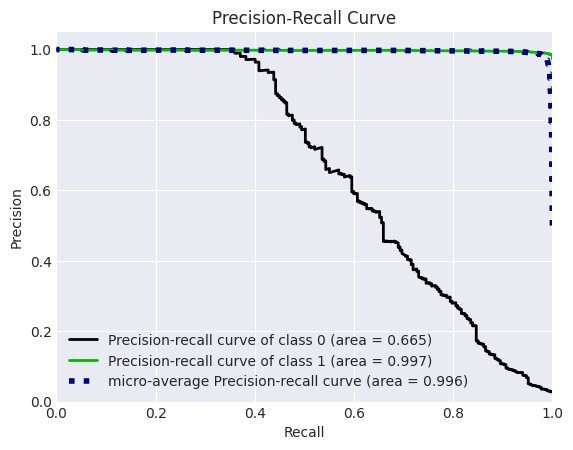

In [74]:
plt.figure(figsize=(8,7))
skplt.metrics.plot_precision_recall(y_test,prob3)
plt.show()

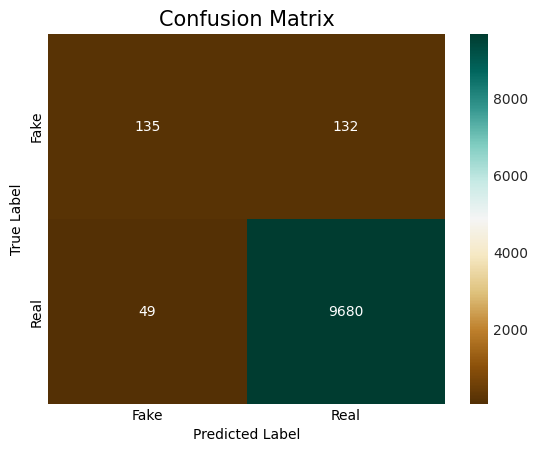

In [75]:
label_name=["Fake","Real"]
cf1= confusion_matrix(y_test,pred3)
sns.heatmap(cf1,annot=True,fmt="d",xticklabels=label_name,yticklabels=label_name,cmap="BrBG")
plt.xlabel("Predicted Label",fontsize=10,color="black")
plt.ylabel("True Label",fontsize=10,color="black")
plt.title("Confusion Matrix",fontsize=15,color="black")
plt.xticks(fontsize=10,color="black")
plt.yticks(fontsize=10,color="black")
plt.show()

In [76]:
print(classification_report(y_test,pred3,target_names=label_name))

              precision    recall  f1-score   support

        Fake       0.73      0.51      0.60       267
        Real       0.99      0.99      0.99      9729

    accuracy                           0.98      9996
   macro avg       0.86      0.75      0.79      9996
weighted avg       0.98      0.98      0.98      9996



In [77]:
# Calculating precision score
precision3 = precision_score(y_test,pred3)
print("=================================================================")
# Printing the precision score
print('Precision Score: %.4f' % precision3)
print("=================================================================")
kappa_score3 = cohen_kappa_score(y_test,pred3)

# Printing the kappa score
print('Cohen\'s Kappa Score: %.4f' % kappa_score3)
print("=================================================================")
roc_auc3 = roc_auc_score(y_test,pred3)

# Printing the ROC AUC score
print('ROC AUC Score: %.4f' % roc_auc3)
print("=================================================================")
# Matthews Correlation Coefficient
mcc3 = matthews_corrcoef(y_test,pred3)
# Printing the MCC
print('MCC Score: %.4f' % mcc3)
print("=================================================================")
log_loss_score3 = log_loss(y_test,pred3)

# Printing the logarithmic loss
print('Logarithmic Loss: %.4f' % log_loss_score3)
print("=================================================================")

brier_score3 = brier_score_loss(y_test,pred3)

# Printing the Brier score
print('Brier Score: %.3f' % brier_score3)
print("=================================================================")

Precision Score: 0.9865
Cohen's Kappa Score: 0.5897
ROC AUC Score: 0.7503
MCC Score: 0.6004
Logarithmic Loss: 0.6527
Brier Score: 0.018


# Model_4_LGB

In [78]:
import lightgbm as lgb

model4 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model4.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.041182	valid_0's binary_logloss: 0.0615716
[40]	training's binary_logloss: 0.0240252	valid_0's binary_logloss: 0.051461
[60]	training's binary_logloss: 0.0154471	valid_0's binary_logloss: 0.0467089
[80]	training's binary_logloss: 0.0106247	valid_0's binary_logloss: 0.0446324
[100]	training's binary_logloss: 0.00769328	valid_0's binary_logloss: 0.0436715


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [79]:
pred4=model4.predict(X_test)
accuracy4= accuracy_score(y_test, pred4)
print(f'Accuracy: {accuracy4:.2f}%')

Accuracy: 0.99%


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

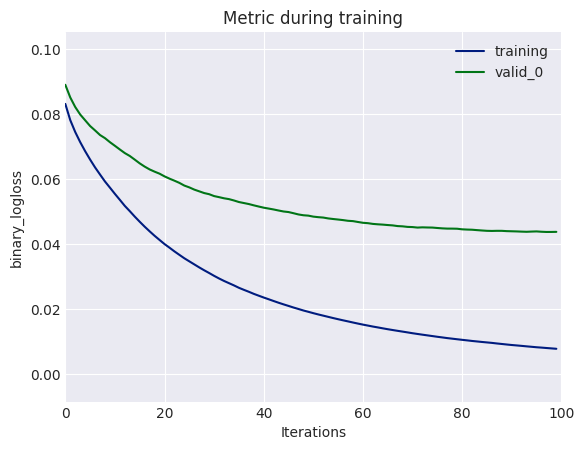

In [80]:
lgb.plot_metric(model4)

<Figure size 1000x600 with 0 Axes>

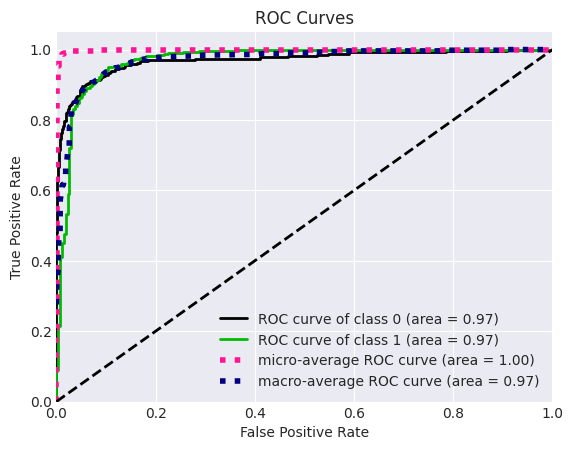

In [81]:
plt.figure(figsize=(10,6))
prob4=model4.predict_proba(X_test)
skplt.metrics.plot_roc(y_test,prob4)
plt.show()

<Figure size 800x700 with 0 Axes>

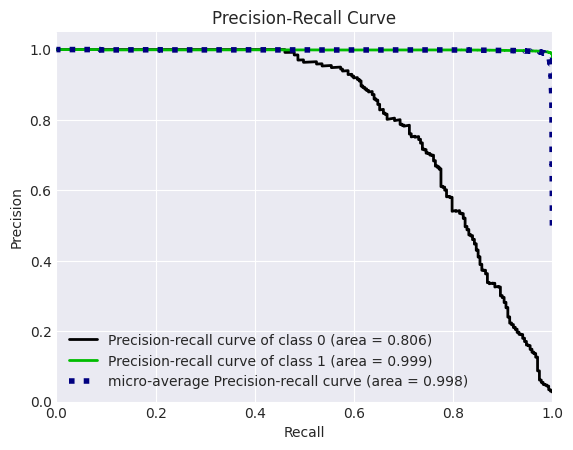

In [82]:
plt.figure(figsize=(8,7))
skplt.metrics.plot_precision_recall(y_test,prob4)
plt.show()

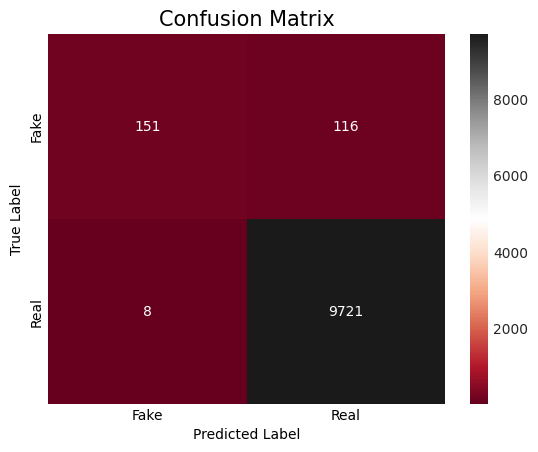

In [83]:
label_name=["Fake","Real"]
cf1= confusion_matrix(y_test,pred4)
sns.heatmap(cf1,annot=True,fmt="d",xticklabels=label_name,yticklabels=label_name,cmap="RdGy")
plt.xlabel("Predicted Label",fontsize=10,color="black")
plt.ylabel("True Label",fontsize=10,color="black")
plt.title("Confusion Matrix",fontsize=15,color="black")
plt.xticks(fontsize=10,color="black")
plt.yticks(fontsize=10,color="black")
plt.show()

In [84]:
print(classification_report(y_test,pred4,target_names=label_name))

              precision    recall  f1-score   support

        Fake       0.95      0.57      0.71       267
        Real       0.99      1.00      0.99      9729

    accuracy                           0.99      9996
   macro avg       0.97      0.78      0.85      9996
weighted avg       0.99      0.99      0.99      9996



In [85]:
# Calculating precision score
precision4 = precision_score(y_test,pred4)
print("=================================================================")
# Printing the precision score
print('Precision Score: %.4f' % precision4)
print("=================================================================")
kappa_score4 = cohen_kappa_score(y_test,pred4)

# Printing the kappa score
print('Cohen\'s Kappa Score: %.4f' % kappa_score4)
print("=================================================================")
roc_auc4= roc_auc_score(y_test,pred4)

# Printing the ROC AUC score
print('ROC AUC Score: %.4f' % roc_auc4)
print("=================================================================")
# Matthews Correlation Coefficient
mcc4 = matthews_corrcoef(y_test,pred4)
# Printing the MCC
print('MCC Score: %.4f' % mcc4)
print("=================================================================")
log_loss_score4 = log_loss(y_test,pred4)

# Printing the logarithmic loss
print('Logarithmic Loss: %.4f' % log_loss_score4)
print("=================================================================")

brier_score4 = brier_score_loss(y_test,pred4)

# Printing the Brier score
print('Brier Score: %.3f' % brier_score4)
print("=================================================================")

Precision Score: 0.9882
Cohen's Kappa Score: 0.7030
ROC AUC Score: 0.7824
MCC Score: 0.7278
Logarithmic Loss: 0.4471
Brier Score: 0.012


# Model_5 Cat Boost Classifier

In [86]:
from catboost import CatBoostClassifier

model5 = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', random_seed=42)
model5.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10)


0:	learn: 0.5309382	test: 0.5313679	best: 0.5313679 (0)	total: 545ms	remaining: 53.9s
10:	learn: 0.1111603	test: 0.1140191	best: 0.1140191 (10)	total: 4.21s	remaining: 34.1s
20:	learn: 0.0775421	test: 0.0826560	best: 0.0826560 (20)	total: 7.93s	remaining: 29.8s
30:	learn: 0.0694330	test: 0.0762173	best: 0.0762173 (30)	total: 11.6s	remaining: 25.8s
40:	learn: 0.0649114	test: 0.0725804	best: 0.0725804 (40)	total: 15.2s	remaining: 21.9s
50:	learn: 0.0608451	test: 0.0697718	best: 0.0697718 (50)	total: 19s	remaining: 18.2s
60:	learn: 0.0582268	test: 0.0679586	best: 0.0679586 (60)	total: 22.5s	remaining: 14.4s
70:	learn: 0.0563199	test: 0.0668985	best: 0.0668985 (70)	total: 25.9s	remaining: 10.6s
80:	learn: 0.0548677	test: 0.0665437	best: 0.0665437 (80)	total: 29.8s	remaining: 6.99s
90:	learn: 0.0534697	test: 0.0657837	best: 0.0657755 (88)	total: 33.3s	remaining: 3.29s
99:	learn: 0.0523987	test: 0.0651865	best: 0.0651865 (99)	total: 36.4s	remaining: 0us

bestTest = 0.0651865367
bestIteration

In [87]:
pred5=model5.predict(X_test)
accuracy5= accuracy_score(y_test, pred5)
print(f'Accuracy: {accuracy5:.2f}%')

Accuracy: 0.98%


<Figure size 1000x600 with 0 Axes>

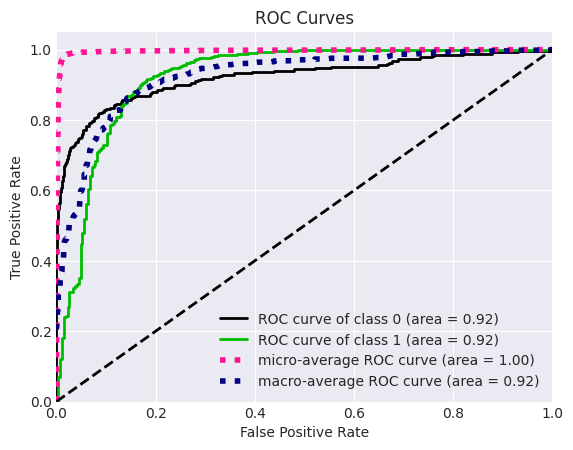

In [88]:
plt.figure(figsize=(10,6))
prob5=model5.predict_proba(X_test)
skplt.metrics.plot_roc(y_test,prob5)
plt.show()

<Figure size 800x700 with 0 Axes>

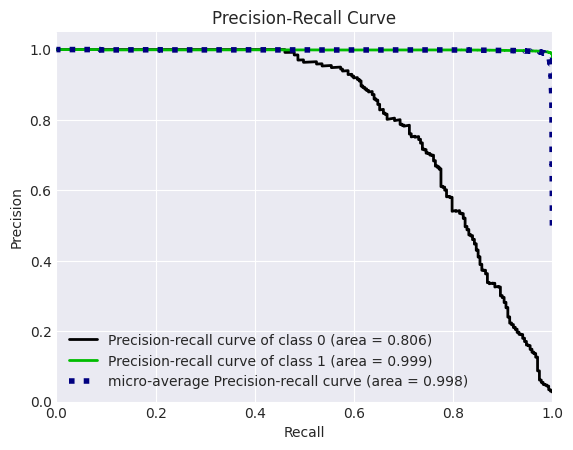

In [89]:
plt.figure(figsize=(8,7))
skplt.metrics.plot_precision_recall(y_test,prob4)
plt.show()

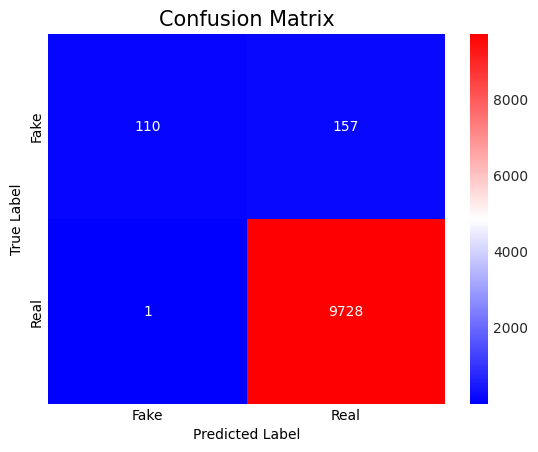

In [90]:
label_name=["Fake","Real"]
cf1= confusion_matrix(y_test,pred5)
sns.heatmap(cf1,annot=True,fmt="d",xticklabels=label_name,yticklabels=label_name,cmap="bwr")
plt.xlabel("Predicted Label",fontsize=10,color="black")
plt.ylabel("True Label",fontsize=10,color="black")
plt.title("Confusion Matrix",fontsize=15,color="black")
plt.xticks(fontsize=10,color="black")
plt.yticks(fontsize=10,color="black")
plt.show()

In [91]:
print(classification_report(y_test,pred5,target_names=label_name))

              precision    recall  f1-score   support

        Fake       0.99      0.41      0.58       267
        Real       0.98      1.00      0.99      9729

    accuracy                           0.98      9996
   macro avg       0.99      0.71      0.79      9996
weighted avg       0.98      0.98      0.98      9996



In [92]:
# Calculating precision score
precision5 = precision_score(y_test,pred5)
print("=================================================================")
# Printing the precision score
print('Precision Score: %.4f' % precision5)
print("=================================================================")
kappa_score5 = cohen_kappa_score(y_test,pred5)

# Printing the kappa score
print('Cohen\'s Kappa Score: %.4f' % kappa_score5)
print("=================================================================")
roc_auc5= roc_auc_score(y_test,pred5)

# Printing the ROC AUC score
print('ROC AUC Score: %.4f' % roc_auc5)
print("=================================================================")
# Matthews Correlation Coefficient
mcc5 = matthews_corrcoef(y_test,pred5)
# Printing the MCC
print('MCC Score: %.4f' % mcc5)
print("=================================================================")
log_loss_score5 = log_loss(y_test,pred5)

# Printing the logarithmic loss
print('Logarithmic Loss: %.4f' % log_loss_score5)
print("=================================================================")

brier_score5 = brier_score_loss(y_test,pred5)

# Printing the Brier score
print('Brier Score: %.3f' % brier_score5)
print("=================================================================")

Precision Score: 0.9841
Cohen's Kappa Score: 0.5753
ROC AUC Score: 0.7059
MCC Score: 0.6337
Logarithmic Loss: 0.5697
Brier Score: 0.016


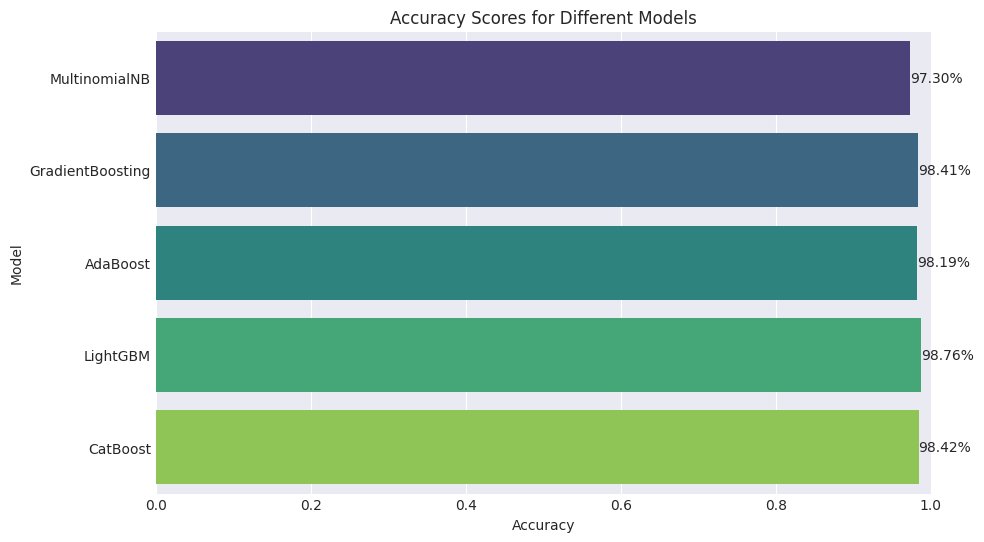

In [93]:


# Accuracy scores
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]

# Model names
model_names = ['MultinomialNB', 'GradientBoosting', 'AdaBoost', 'LightGBM', 'CatBoost']

# Create a DataFrame for seaborn
data = {'Model': model_names, 'Accuracy': accuracies}
df = pd.DataFrame(data)

# Create a barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Accuracy', y='Model', data=df, palette='viridis')
plt.title('Accuracy Scores for Different Models')
plt.xlim(0, 1)  # Set x-axis limit to match the accuracy range (0 to 1)

# Annotate bars with accuracy scores
for index, value in enumerate(accuracies):
    barplot.text(value, index, f'{value:.2%}', va='center', fontsize=10)

plt.show()
